In [1]:
import son_analyze
import son_scikit
print('Welcome to son-analyze v{} and son-scikit v{}.'.format(son_analyze.__version__, son_scikit.__version__))

Welcome to son-analyze v0.0.1 and son-scikit v0.0.1.


In [2]:
import helpers
print('You can use and tweak the python code in the helpers.py file (example: "{}")'.format(helpers.foobar()))

You can use and tweak the python code in the helpers.py file (example: "foobar")


In [3]:
import json
import arrow
import requests
from son_analyze.core.prometheus import PrometheusData
from son_scikit.hl_prometheus import build_sonata_df_by_id

#from http.client import HTTPConnection
#HTTPConnection.debuglevel = 1

query = 'sonemu_rx_count_packets{vnf_name="ubuntu_vnf1",vnf_interface="port1"}'
end = arrow.utcnow()
print('The current date is: {}'.format(end))
start = end.replace(minutes=-50)
payload = {'query': query, 'start': start.timestamp, 'end': end.timestamp, 'step': '1s'}
req = requests.get('http://173.17.0.1:9090/api/v1/query_range?',
                   params=payload)
#print('---')
#print(req.content)

x = PrometheusData(json.dumps(req.json()))
y = build_sonata_df_by_id(x)


The current date is: 2016-11-23T18:15:25.737086+00:00


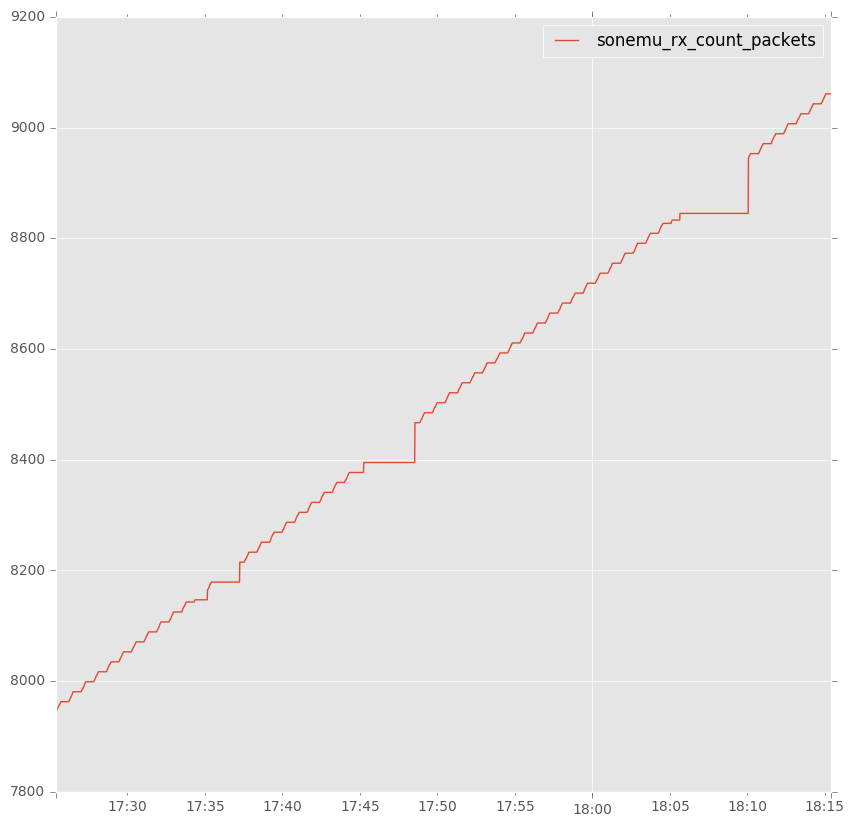

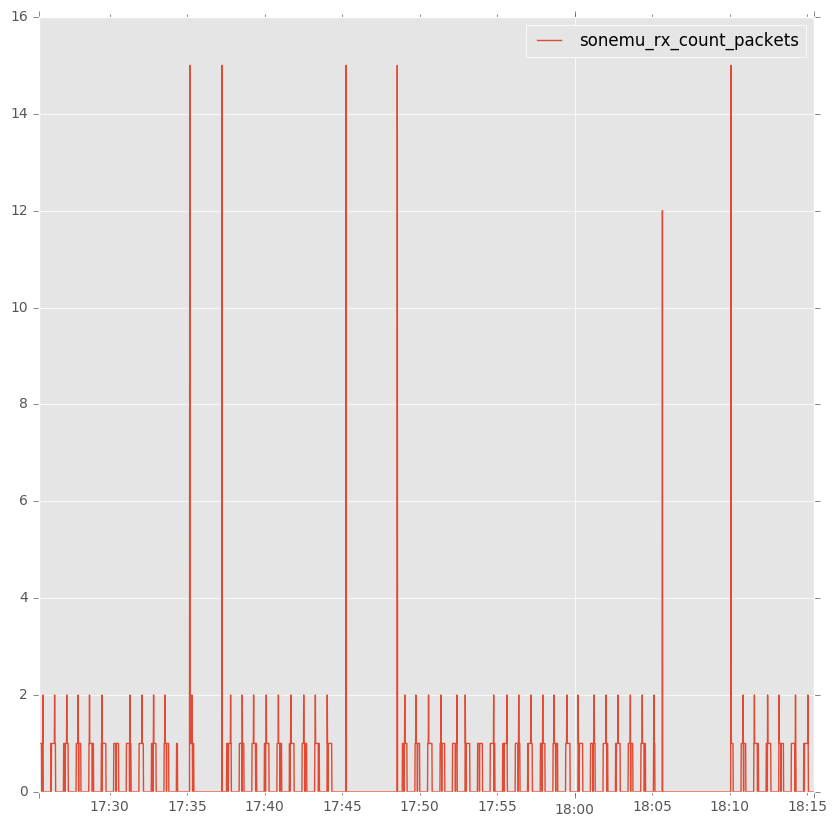

In [4]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)

df = y['ubuntu_vnf1']

def sanitize(x):
    return min(15.0, x)

ddf = df.diff().dropna()
ddfn = ddf.copy()
ddfn.sonemu_rx_count_packets = ddfn.sonemu_rx_count_packets.apply(sanitize)
df.plot()
#ddf.plot(logy=True)
ddfn.plot()

In [5]:
import datetime
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.stattools import adfuller, arma_order_select_ic


### see http://statsmodels.sourceforge.net/0.6.0/generated/statsmodels.tsa.arima_model.ARMAResults.plot_predict.html

/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Results: ARMA
Model:                ARMA                     BIC:                  6677.3584 
Dependent Variable:   sonemu_rx_count_packets  Log-Likelihood:       -3306.7   
Date:                 2016-11-23 18:15         Scale:                1.0000    
No. Observations:     3000                     Method:               css-mle   
Df Model:             7                        Sample:               11-23-2016
Df Residuals:         2993                                           11-23-2016
Converged:            0.0000                   S.D. of innovations:  0.728     
AIC:                  6629.3075                HQIC:                 6646.591  
-------------------------------------------------------------------------------
                               Coef.  Std.Err.     t     P>|t|   [0.025  0.975]
-------------------------------------------------------------------------------
const                          0.3153   0.0137   23.0348 0.0000  0.2885  

/opt/conda/lib/python3.5/site-packages/statsmodels/tsa/arima_model.py:1724: FutureWarning: TimeSeries is deprecated. Please use Series
  forecast = TimeSeries(forecast, index=self.data.predict_dates)


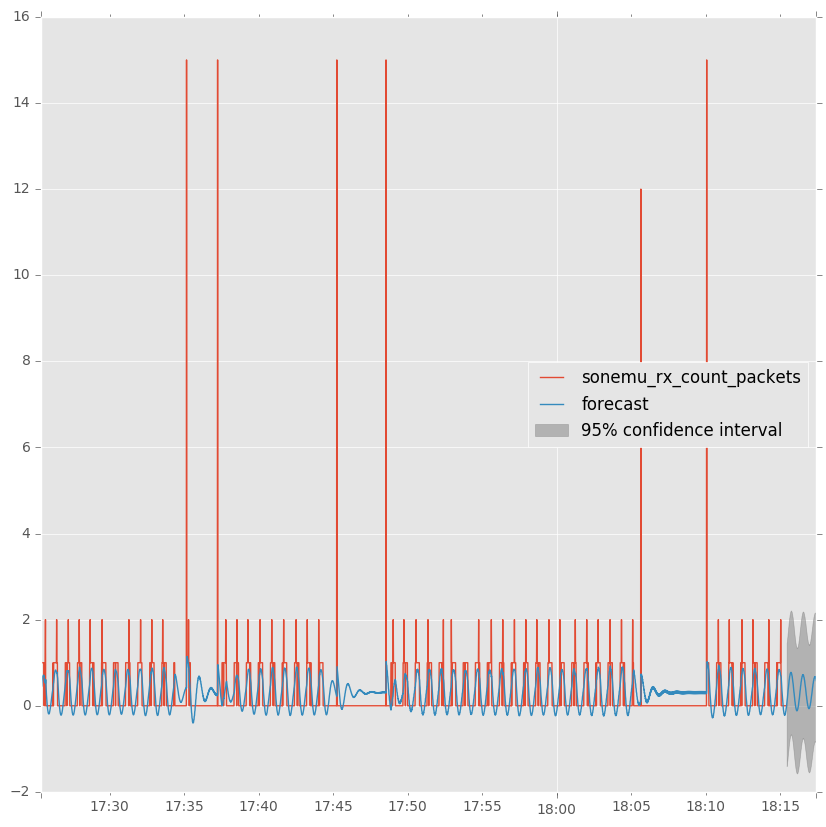

In [6]:
target_arma = ddfn
results_arma = sm.tsa.ARMA(target_arma, (3, 3)).fit()
print(results_arma.summary2())
fig, ax = plt.subplots()
ax = target_arma.plot(ax=ax, logy=False)
fig = results_arma.plot_predict(start=1, end=len(target_arma.index)+120, ax=ax, plot_insample=False)
plt.show()

/opt/conda/lib/python3.5/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]
/opt/conda/lib/python3.5/site-packages/pyculiarity/detect_anoms.py:81: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  'value': (decomp['trend'] + decomp['seasonal']).truncate().convert_objects(convert_numeric=True)


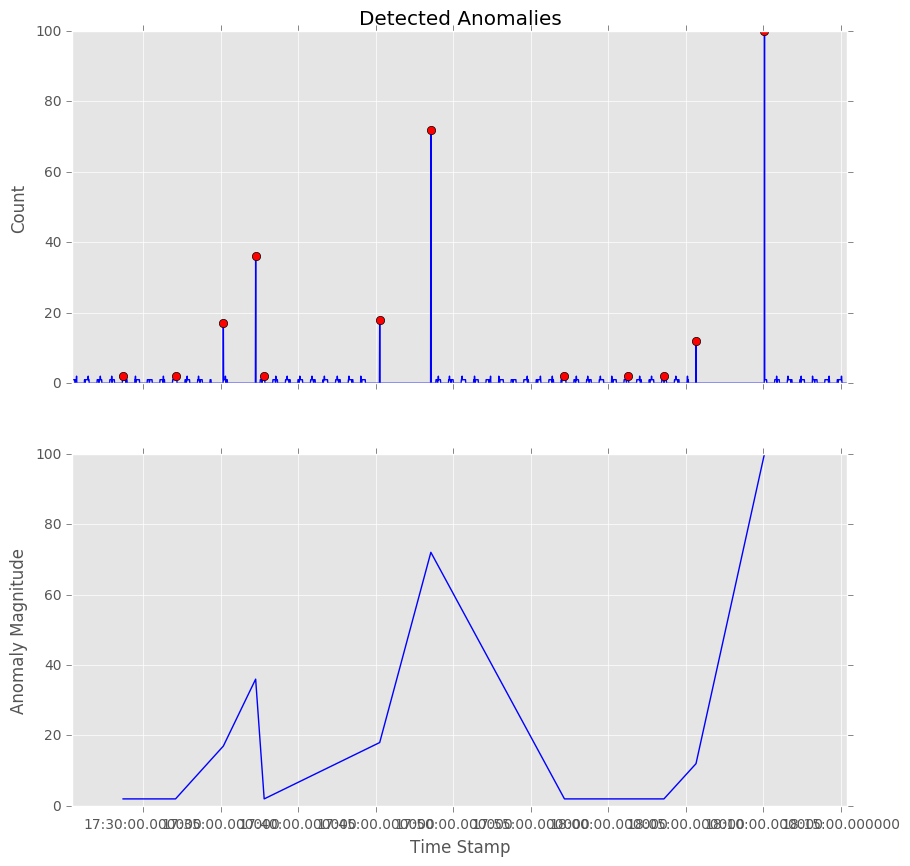

In [7]:
from pyculiarity import detect_ts
import pandas as pd
import time


def f(x):
    dt = x.to_datetime()
    return time.mktime(dt.timetuple())

target = ddf
u = pd.DataFrame({'one': list(target.index.map(f)), 'two': target.sonemu_rx_count_packets})
results = detect_ts(u, max_anoms=0.004, alpha=0.01, direction='both') #, threshold='med_max')

#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

# make a nice plot
f, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(target.index, target.sonemu_rx_count_packets, 'b')
ax[0].plot(results['anoms'].index, results['anoms']['anoms'], 'ro')
ax[0].set_title('Detected Anomalies')
ax[1].set_xlabel('Time Stamp')
ax[0].set_ylabel('Count')
ax[1].plot(results['anoms'].index, results['anoms']['anoms'], 'b')
ax[1].set_ylabel('Anomaly Magnitude')
plt.show()
    
